Questions à répondre:
- Calculer chiffres d'affaires( total, annuel,mensuel)
- Evolution chifrre d'affaire mois d'octobre
- moyenne mobile
- Zoom sur les références
- Repartition du CA par produits
- Repartition des references parmis les categories
- informations sur les profils de nos clients
- Répartition du chiffre d'affaires entre les clients
- Répartition des genres au sein de notre clientèle
- Participation au chiffre d'affaires par genres
- Analyse de la corrélation entre le sexe des clients et les catégories de produits achetés
- Analyse de la corrélation entre l'âge clients et le montant total des achats
- Analyse de la corrélation entre l'âge clients et la fréquence d'achat
- Analyse de la corrélation entre l'âge clients et la taille du panier moyen
- Analyse de la corrélation entre l'âge clients et la catégorie produits




### 1.Import des librairies Python

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import scipy.stats as st
import statsmodels.api as sm
from statsmodels.formula.api import ols
from string import*
from scipy.stats import kruskal, spearmanr, ttest_ind, chi2_contingency, pearsonr, shapiro
colors = ["#b2eca7","#ffcc97","#676283","#72bbff","#d2a0f2","#0abdc0"]

## 2.Import des fichiers csv de la base de données de l’entreprise

In [3]:
transactions = pd.read_csv("transactions.csv")
customers = pd.read_csv("customers.csv")
products = pd.read_csv("products.csv")

### 3.Nettoyage des données

In [3]:
#Visualisation des dataframes
print("Info des dataframes")
print(products.info())
print("*********")
print(customers.info())
print("***********")
print(transactions.info())
print("------------------------")
print("Description des dataframes ")
print(products.describe())
print("___________")
print(customers.describe())
print("____________")
print(transactions.describe())


Info des dataframes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
id_prod    3287 non-null object
price      3287 non-null float64
categ      3287 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 77.1+ KB
None
*********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
client_id    8623 non-null object
sex          8623 non-null object
birth        8623 non-null int64
dtypes: int64(1), object(2)
memory usage: 202.2+ KB
None
***********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679532 entries, 0 to 679531
Data columns (total 4 columns):
id_prod       679532 non-null object
date          679532 non-null object
session_id    679532 non-null object
client_id     679532 non-null object
dtypes: object(4)
memory usage: 20.7+ MB
None
------------------------
Description des dataframes 
             price        categ
count  3287.000000  3287.000000
mea

In [7]:
# Vérification des doublons des dataframes
print(products.duplicated().values.any())
print(customers.duplicated().values.any())
print(transactions.duplicated().values.any())

False
False
True


In [8]:
# compter nombre de doublons dans dataframe transactions
print(transactions.duplicated().sum())

126


## Observations:

### Observation dataframe Products:
- Contient 3287 produits 
- categorie composé de 0,1 et 2 
- prix compris de -1 à 300 
- pas de valeurs nulles
- pas de doublons

### Observation dataframe customers:
- Contient 8623 clients
- sex composé de m et f
- birth compris de 1929 à 2004
- pas de valeurs nulles
- pas de doublons


### Observation dataframe transactions:
- Contient 679532 transactions 
- pas de valeurs nulles
- il y a 126 doublons avec le id_prod : T_0

## 3.1 Correction du dataframe products :

In [9]:
# Suppression du price -1:
products.loc[products['price']== -1,:]

,id_prod,price,categ
731,T_0,-1.0,0


In [10]:
products.drop(products[(products["id_prod"] == "T_0")].index, inplace=True)

## 3.2 Correction du dataframe customers :

In [11]:
customers.sort_values('client_id', ascending = False).head()

,client_id,sex,birth
8494,ct_1,m,2001
2735,ct_0,f,2001
7358,c_999,m,1964
2145,c_998,m,2001
94,c_997,f,1994


In [12]:
customers.sort_values('client_id', ascending = False).tail()

,client_id,sex,birth
3426,c_1001,m,1982
8472,c_1000,f,1966
2137,c_100,m,1992
6894,c_10,m,1956
4299,c_1,m,1955


 Dans la colonne client_id, ct_1 et ct_2 n'ont pas la même formrne d'écriture que les autres, le "ct" ressemble à un identifiant de test.

In [13]:
#Suppression des deux lignes client_id ct_1 et ct_2
customers = customers[(customers.client_id != 'ct_0') & (customers.client_id != 'ct_1')]

## 3.2 Correction du dataframe transactions :

In [14]:
# On supprime les 126 doublons dand le dataframe transactions
transactions = transactions.drop_duplicates()

In [15]:
transactions = transactions[~transactions.date.str.contains("test")]

In [16]:
transactions.dtypes

id_prod       object
date          object
session_id    object
client_id     object
dtype: object

In [17]:
#Conversion des valeurs de la colonne 'date' en format date 
transactions.date=pd.to_datetime(transactions.date)
transactions.date=transactions.date.dt.strftime('%Y-%m-%d')
transactions['date'] =  pd.to_datetime(transactions['date'])

transactions.dtypes

id_prod               object
date          datetime64[ns]
session_id            object
client_id             object
dtype: object

## 4.Jointure des dataframes:

In [18]:
#Premiere jointure des valeurs des dataframes transactions et customers
transactions_customers = pd.merge(transactions, customers, on="client_id", how="left")
transactions_customers.head()

,id_prod,date,session_id,client_id,sex,birth
0,0_1518,2022-05-20,s_211425,c_103,f,1986
1,1_251,2022-02-02,s_158752,c_8534,m,1988
2,0_1277,2022-06-18,s_225667,c_6714,f,1968
3,2_209,2021-06-24,s_52962,c_6941,m,2000
4,0_1509,2023-01-11,s_325227,c_4232,m,1980


In [19]:
#Seconde jointure des valeurs des dataframes transactions_customers et products
data_complet = pd.merge(transactions_customers, products, on="id_prod", how="left")
data_complet.head()

,id_prod,date,session_id,client_id,sex,birth,price,categ
0,0_1518,2022-05-20,s_211425,c_103,f,1986,4.18,0.0
1,1_251,2022-02-02,s_158752,c_8534,m,1988,15.99,1.0
2,0_1277,2022-06-18,s_225667,c_6714,f,1968,7.99,0.0
3,2_209,2021-06-24,s_52962,c_6941,m,2000,69.99,2.0
4,0_1509,2023-01-11,s_325227,c_4232,m,1980,4.99,0.0


In [20]:
#Vérification d'éventuelles valeurs manquantes 
data_complet.isnull().sum()

id_prod         0
date            0
session_id      0
client_id       0
sex             0
birth           0
price         221
categ         221
dtype: int64

In [21]:
#Création d'un dataframe ciblant uniquement ces NaN
missing_values = data_complet[data_complet.categ.isnull() == True]

In [22]:
#Recherche du ou des produits concernés
missing_values.id_prod.unique()

array(['0_2245'], dtype=object)

Seul le produit id 0_2245 est concerné par les valeurs manquantes.

In [23]:
# On ajoute le produits 0_2245 dans le dataframe produits en remplacant les prix NaN par le prix moyen
mean_price =products.query("categ==0")['price'].mean()
print(mean_price)
new_row = {'id_prod': '0_2245', 'price':mean_price, 'categ':0}
products= products.append(new_row, ignore_index=True)
products.loc[products['id_prod']== '0_2245',:]

11.732794627383296


,id_prod,price,categ
3286,0_2245,11.732795,0


In [24]:
data_complet[data_complet.date.isnull() == True]

,id_prod,date,session_id,client_id,sex,birth,price,categ


In [25]:
data_complet = data_complet.dropna()

In [26]:
#Nouvelle vérification des valeurs manquantes
data_complet.isnull().sum()

id_prod       0
date          0
session_id    0
client_id     0
sex           0
birth         0
price         0
categ         0
dtype: int64

In [27]:
# Extraction de l'année, du mois et du jour dans 3 nouvelles colonnes

data_complet["date_y"] = data_complet["date"].dt.strftime("%Y")
data_complet["date_m"] = data_complet["date"].dt.strftime("%m")
data_complet["date_d"] = data_complet["date"].dt.strftime("%d")

# Regroupement de l'année, du mois et du jour dans une colonne date_y_m_d

data_complet["date_y_m_d"] = data_complet["date_y"] + "-" + data_complet["date_m"] + "-" + data_complet["date_d"]

# Regroupement de l'année et du mois dans une colonne date_y_m

data_complet["date_y_m"] = data_complet["date_y"] + "-" + data_complet["date_m"]

# Affichage et infos de la nouvelle table

print("Informations sur la nouvelle table data :\n")
data_complet.info()
print("\nTable data avec la colonne date_y_m :")
data_complet.head()

Informations sur la nouvelle table data :

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679111 entries, 0 to 679331
Data columns (total 13 columns):
id_prod       679111 non-null object
date          679111 non-null datetime64[ns]
session_id    679111 non-null object
client_id     679111 non-null object
sex           679111 non-null object
birth         679111 non-null int64
price         679111 non-null float64
categ         679111 non-null float64
date_y        679111 non-null object
date_m        679111 non-null object
date_d        679111 non-null object
date_y_m_d    679111 non-null object
date_y_m      679111 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(9)
memory usage: 72.5+ MB

Table data avec la colonne date_y_m :


,id_prod,date,session_id,client_id,sex,birth,price,categ,date_y,date_m,date_d,date_y_m_d,date_y_m
0,0_1518,2022-05-20,s_211425,c_103,f,1986,4.18,0.0,2022,05,20,2022-05-20,2022-05
1,1_251,2022-02-02,s_158752,c_8534,m,1988,15.99,1.0,2022,02,02,2022-02-02,2022-02
2,0_1277,2022-06-18,s_225667,c_6714,f,1968,7.99,0.0,2022,06,18,2022-06-18,2022-06
3,2_209,2021-06-24,s_52962,c_6941,m,2000,69.99,2.0,2021,06,24,2021-06-24,2021-06
4,0_1509,2023-01-11,s_325227,c_4232,m,1980,4.99,0.0,2023,01,11,2023-01-11,2023-01


   # 5.Réponse à Antoine 

### 5.1 Analyse de l'évolution du chiffre d'affaires total ,annuel et mensuel

In [28]:
# Calcul chiffre d'affaires total et nombre total d'articles vendus
ca_total = round(data_complet["price"].sum(),2)
print("Le chiffre d'affaires total est de", ca_total, "€")
Nbre_ventes = data_complet["session_id"].count()
print("le nombre total d'articles vendus",Nbre_ventes)

Le chiffre d'affaires total est de 11853728.68 €
le nombre total d'articles vendus 679111


In [29]:
# Calcul du chiffre d'affaires annuel et nombre de ventes annuel
ca_annuel = data_complet.groupby(["date_y"])[["price"]].sum()
ca_annuel.reset_index(inplace = True)
print("Chiffres d'affaires annuels:\n", ca_annuel)
ventes_annuelles = data_complet.groupby(["date_y"])["session_id"].count()
print("Nombre de ventes annuelles:\n", ventes_annuelles)

Chiffres d'affaires annuels:
   date_y         price
0   2021  4.770827e+06
1   2022  6.108682e+06
2   2023  9.742203e+05
Nombre de ventes annuelles:
 date_y
2021    278248
2022    346380
2023     54483
Name: session_id, dtype: int64


<BarContainer object of 3 artists>

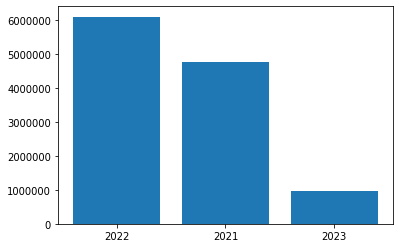

In [30]:
# Diagramme en bâtons du chiffres d'affaires annuel
ca_annuel_sorted= ca_annuel.sort_values('price', ascending=False)
plt.bar(height=ca_annuel_sorted['price'], x=ca_annuel_sorted['date_y'])

In [31]:
# Calcul chiffre d'affaires mensuel:
ca_mensuel = data_complet.groupby(["date_y_m"])[["price"]].sum()
ca_mensuel.reset_index(inplace=True)
ca_mensuel.head()

,date_y_m,price
0,2021-03,482440.61
1,2021-04,476109.30
2,2021-05,492943.47
3,2021-06,484088.56
4,2021-07,482835.40


No handles with labels found to put in legend.


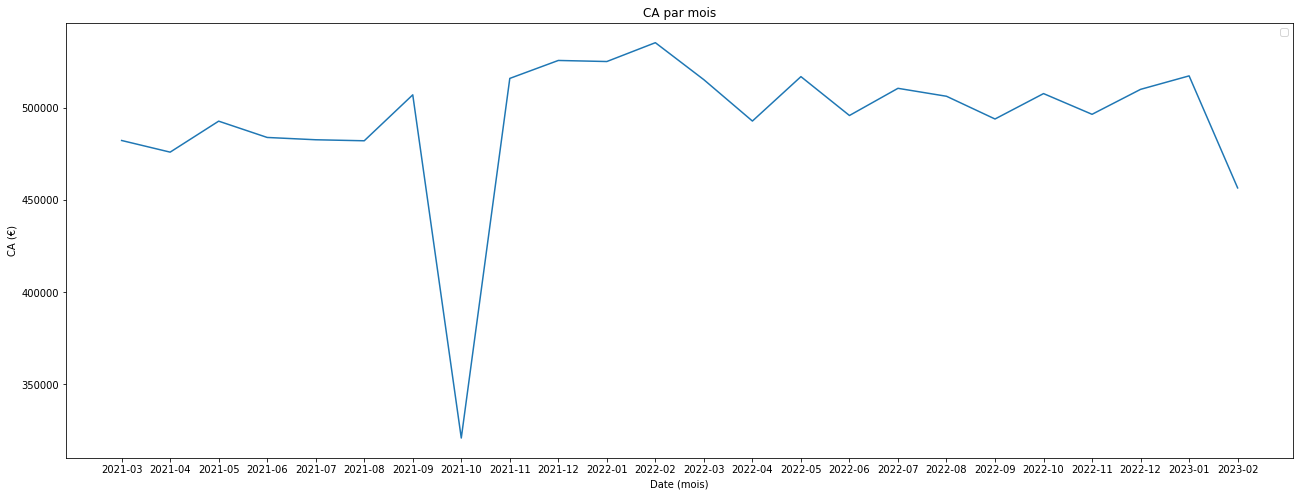

In [32]:
# évolution du CA mensuel
plt.figure(figsize = (22,8))
plt.plot(ca_mensuel['date_y_m'], ca_mensuel["price"])
plt.xlabel('Date (mois)')
plt.ylabel("CA (€)")
plt.title("CA par mois")
plt.legend()

 Baisse du chiffre d'affaires  en octobre.

### 5.2 Etude de la baisse du chiffre d'affaires en octobre.

In [33]:
data_complet.drop(['date'], axis=1,inplace=True)
data_complet.head()

,id_prod,session_id,client_id,sex,birth,price,categ,date_y,date_m,date_d,date_y_m_d,date_y_m
0,0_1518,s_211425,c_103,f,1986,4.18,0.0,2022,05,20,2022-05-20,2022-05
1,1_251,s_158752,c_8534,m,1988,15.99,1.0,2022,02,02,2022-02-02,2022-02
2,0_1277,s_225667,c_6714,f,1968,7.99,0.0,2022,06,18,2022-06-18,2022-06
3,2_209,s_52962,c_6941,m,2000,69.99,2.0,2021,06,24,2021-06-24,2021-06
4,0_1509,s_325227,c_4232,m,1980,4.99,0.0,2023,01,11,2023-01-11,2023-01


In [34]:
#Création de dataframes pour les trois catégories de produits pour le mois d'octobre
data_complet_categ = data_complet.query("date_y_m =='2021-10'")[["categ", "price", "date_y_m_d"]]
data_complet_categ = pd.pivot_table(data_complet_categ, index=["date_y_m_d"], columns=["categ"], aggfunc=["sum", "count"]).reset_index()
data_complet_categ.columns = ["date_y_m_d", "categ_0", "categ_1", "categ_2", "vol_categ_0", "vol_categ_1", "vol_categ_2"]
data_complet_categ.head()

,date_y_m_d,categ_0,categ_1,categ_2,vol_categ_0,vol_categ_1,vol_categ_2
0,2021-10-01,6950.50,7003.79,3104.05,663.0,344.0,38.0
1,2021-10-02,7141.01,NaN,2041.12,661.0,NaN,28.0
2,2021-10-03,6786.57,NaN,2206.48,648.0,NaN,31.0
3,2021-10-04,6533.60,NaN,2746.08,601.0,NaN,38.0
4,2021-10-05,6357.91,NaN,3032.55,594.0,NaN,38.0


ValueError: shape mismatch: objects cannot be broadcast to a single shape

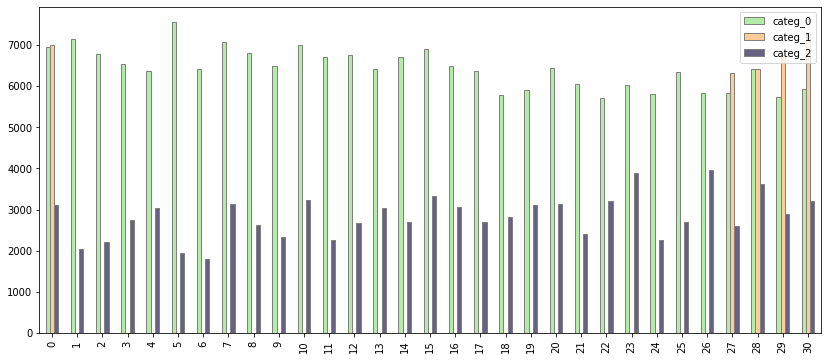

In [37]:
# Graphique CA par mois:
data_complet_categ[["categ_0", "categ_1", "categ_2"]].plot.bar(figsize=(14,6),color=colors,edgecolor = "grey", linewidth = 1)
plt.bar(height=data_complet_categ[["categ_0", "categ_1", "categ_2"]], x=data_complet_categ['date_y_m_d'],figsize=(14,6),color=colors,edgecolor = "grey", linewidth = 1)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

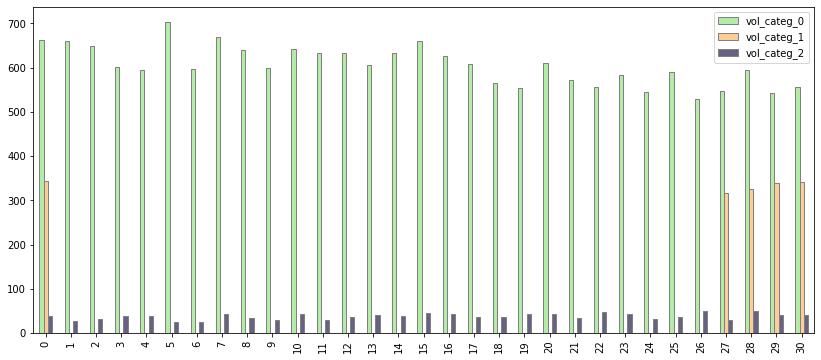

In [39]:
# Graphique volume des ventes:
data_complet_categ[["vol_categ_0", "vol_categ_1", "vol_categ_2"]].plot.bar(figsize=(14,6),color=colors,edgecolor = "grey", linewidth = 1)
plt.bar(height=data_complet_categ[["vol_categ_0", "vol_categ_1", "vol_categ_2"]], x=data_complet_categ['date_y_m_d'],figsize=(14,6),color=colors,edgecolor = "grey", linewidth = 1)


 On constate dans le graphique, aucun achat n'a été enregistré entre le 1 et le 26 octobre 2021 pour les produits de catégorie 1, ce qui explique une baisse de CA à cette période pour les produits de catégorie 1

### 5.3 Decomposition en moyenne mobile:

               price
date_y_m            
2021-03          NaN
2021-04   479274.955
2021-05   484526.385
2021-06   488516.015
2021-07   483461.980
2021-08   482560.095
2021-09   494762.735
2021-10   414019.710
2021-11   418483.235
2021-12   521042.505
2022-01   525628.135
2022-02   530455.245
2022-03   525514.015
2022-04   504227.735
2022-05   505065.770
2022-06   506574.360
2022-07   503399.620
2022-08   508625.195
2022-09   500290.900
2022-10   501016.150
2022-11   502291.355
2022-12   503442.220
2023-01   513880.025
2023-02   487110.155


Text(0.5, 1.0, "Moyenne mobile du chiffre d'affaire")

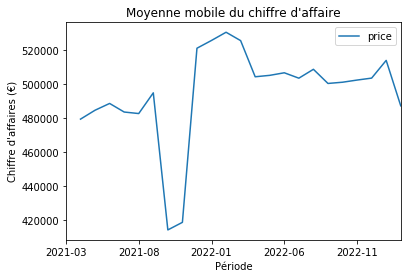

In [40]:
# Decomposition en moyenne mobile pour chaque semaine
moving_average = ca_mensuel.set_index('date_y_m').rolling(window=2).mean()
#data_complet.loc["date_y_m_d","price"].rolling(window=30).mean().plot()
print(moving_average)

# Graphique:
moving_average.plot()
plt.xlabel("Période")
plt.ylabel("Chiffre d'affaires (€)")
plt.title("Moyenne mobile du chiffre d'affaire")

on observer une baisse du CA au mois d'octobre

### 6. Zoom sur les références

In [41]:
#Zoom sur les références tops et flops
nbre_ventes_ref = data_complet.groupby(["id_prod"])["price"].sum()

print("Références les plus vendues")
print(nbre_ventes_ref.nlargest(10))
print("Références les moins vendues")
print(nbre_ventes_ref.nsmallest(10))

Références les plus vendues
id_prod
2_159    94893.50
2_135    69334.95
2_112    65407.76
2_102    60736.78
2_209    56971.86
1_395    54356.25
1_369    54025.48
2_110    53846.25
2_39     53060.85
2_166    52449.12
Name: price, dtype: float64
Références les moins vendues
id_prod
0_1539    0.99
0_1284    1.38
0_1653    1.98
0_1601    1.99
0_541     1.99
0_807     1.99
0_1728    2.27
0_1498    2.48
0_898     2.54
0_1840    2.56
Name: price, dtype: float64


Parmis les 10  tops produits , 8 produits appartiennent  à la catégorie 2  et 2 produits à la catégorie 1 , tandis que les dix pires ventes appartiennent  à la catégorie 0.

### 7.Repartition du CA par produits

indice de Gini: 0.743


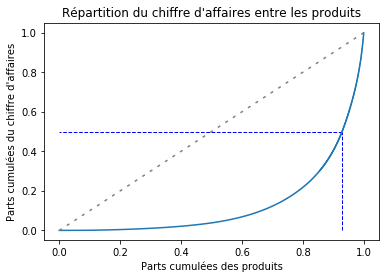

In [44]:
# Courbe de Lorentz
lorenz_ca_produit = np.cumsum(np.sort(nbre_ventes_ref)) / nbre_ventes_ref.sum()
lorenz_ca_produit = np.append([0], lorenz_ca_produit)
plt.plot(np.linspace(0,1,len(lorenz_ca_produit)), lorenz_ca_produit, drawstyle='steps-post'),
plt.plot(np.linspace(0,1,len(lorenz_ca_produit)), np.linspace(0,1,len(lorenz_ca_produit)),color ="grey", dashes=[2,4])
plt.vlines(x=0.9286589099816289, ymin=0, ymax=.5, color='blue', linestyle='--', linewidth=1, label='Medial')
plt.hlines(xmin=0.9286589099816289, xmax=0, y=.5, color='blue', linestyle='--', linewidth=1)

plt.ylabel("Parts cumulées du chiffre d'affaires")
plt.xlabel("Parts cumulées des produits")
plt.title("Répartition du chiffre d'affaires entre les produits")
aire_ss_courbe_ca_produit = lorenz_ca_produit[:-1].sum() / len(lorenz_ca_produit)
S_ca_produit = 0.5 - aire_ss_courbe_ca_produit
gini_ca_produit = 2* S_ca_produit
print("indice de Gini:",round(gini_ca_produit,3))

In [43]:
# calcul de la médiale

medial = lorenz_ca_produit[(lorenz_ca_produit < 0.5)].size / lorenz_ca_produit.size
medial

0.9286589099816289

L'indice de Gini qui vaut 0,743 s'éloigne fortement de 0, le poids des produits dans le chiffre d'affaires global est donc très inégal.

###  7.Repartition des references parmis les categories:

Répartitions des références par catégories:
 categ
0    2309
1     739
2     239
Name: id_prod, dtype: int64
Nombre de ventes par catégories:
 categ
0.0    415459
1.0    227169
2.0     36483
Name: session_id, dtype: int64
Prix moyen d'un livre selon sa catégorie:
 categ
0     11.732795
1     25.531421
2    108.354686
Name: price, dtype: float64
Chiffre d'affaires par catégorie
 categ
0.0    4.419731e+06
1.0    4.653723e+06
2.0    2.780275e+06
Name: price, dtype: float64


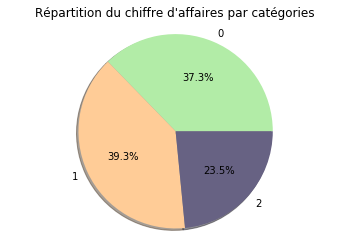

In [40]:
# Repartition des references parmis les categories:
repartition_categorie = products.groupby(["categ"])["id_prod"].count()
print("Répartitions des références par catégories:\n",repartition_categorie)

# Volume de ventes par categories:
vol_categorie = data_complet.groupby(["categ"])["session_id"].count()

print("Nombre de ventes par catégories:\n", vol_categorie)

# Prix moyen par categories:
prix_categorie = products.groupby(["categ"])["price"].mean()
print("Prix moyen d'un livre selon sa catégorie:\n",prix_categorie)

# CA par categories:
ca_categorie = data_complet.groupby(data_complet["categ"])["price"].sum()
print("Chiffre d'affaires par catégorie\n",ca_categorie)

# Graphique:
fig1, ax1 = plt.subplots()
ax1.pie(ca_categorie,
        labels=["0","1","2"],
        autopct="%1.1f%%",
        colors=colors,
        shadow=True)
ax1.axis("equal")
plt.title("Répartition du chiffre d'affaires par catégories")
plt.show()

On note  que nos meilleures ventes se font sur la catégorie 1.

### 8.informations sur les profils de nos clients

In [45]:
# meilleurs clients
best_client = data_complet.groupby(["client_id"])["price"].sum()

print("Clients ayant le plus dépensé")
print(best_client.nlargest(10))

Clients ayant le plus dépensé
client_id
c_1609    324033.35
c_4958    289760.34
c_6714    153598.92
c_3454    113637.93
c_3263      5276.87
c_1570      5271.62
c_2899      5214.05
c_2140      5208.82
c_7319      5155.77
c_7959      5085.45
Name: price, dtype: float64


 c_1609 est le meilleur client

indice de Gini: 0.447


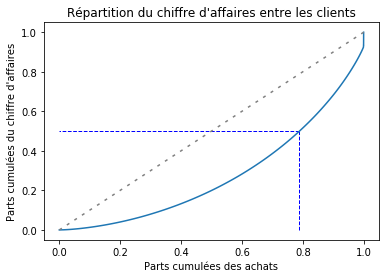

In [49]:
# Courbe de Lorentz: (repartition du CA par clients)
lorenz_CA_client = np.cumsum(np.sort(best_client)) / best_client.sum()
lorenz_CA_client = np.append([0], lorenz_CA_client)
plt.plot(np.linspace(0,1,len(lorenz_CA_client)), lorenz_CA_client, drawstyle="steps-post")
plt.plot(np.linspace(0,1,len(lorenz_CA_client)), np.linspace(0,1,len(lorenz_CA_client)), color ="grey", dashes=[2,4])
plt.vlines(x=0.7890942913614696, ymin=0, ymax=.5, color='blue', linestyle='--', linewidth=1, label='Medial')
plt.hlines(xmin=0.7890942913614696, xmax=0, y=.5, color='blue', linestyle='--', linewidth=1)
plt.ylabel("Parts cumulées du chiffre d'affaires")
plt.xlabel("Parts cumulées des achats")
plt.title("Répartition du chiffre d'affaires entre les clients")
aire_ss_courbe_CA_client = lorenz_CA_client[:-1].sum() / len(lorenz_CA_client)
S_ca_client = 0.5 - aire_ss_courbe_CA_client
gini_CA_client = 2*S_ca_client
print("indice de Gini:",round(gini_CA_client,3))

In [47]:
# calcul de la médiale

medial_1 = lorenz_CA_client[(lorenz_CA_client < 0.5)].size / lorenz_CA_client.size
medial_1

0.7890942913614696

On constate que 79% des achats représentent 50% du montant total des prix de vente.

### 9.Répartition des genres au sein de notre clientèle

sex
f    338285
m    340826
Name: client_id, dtype: int64


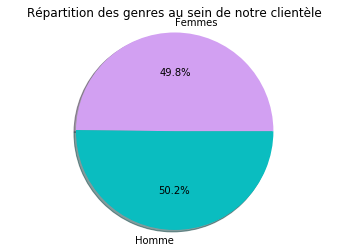

In [50]:
# Repartition des genres parmis nos clients:
repartition_genre = data_complet.groupby(["sex"])["client_id"].count()
print(repartition_genre)

# Graphique:
fig2, ax2 = plt.subplots()
ax2.pie(repartition_genre,
        labels=["Femmes","Homme"],
        autopct="%1.1f%%",
        colors=["#d2a0f2","#0abdc0"],
        shadow=True)
ax2.axis("equal")
plt.title("Répartition des genres au sein de notre clientèle")
plt.show()

### 10.Participation au chiffre d'affaires par genres

montant total des achats par genre:
 sex
f    5.859683e+06
m    5.994046e+06
Name: price, dtype: float64
nombre total d'achats par genre:
 sex
f    338285
m    340826
Name: price, dtype: int64
montant moyen des achats par genre:
 sex
f    17.321735
m    17.586820
Name: price, dtype: float64


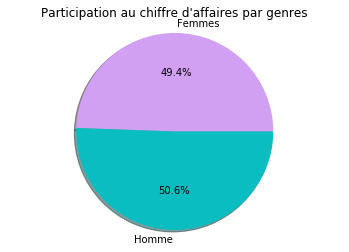

In [51]:
# Depenses par genres:
repartition_achats_genre = data_complet.groupby(["sex"])["price"].sum()
print("montant total des achats par genre:\n", repartition_achats_genre)

nbr_achats_genre = data_complet.groupby(["sex"])["price"].count()
print("nombre total d'achats par genre:\n", nbr_achats_genre)

moy_achats_genre = data_complet.groupby(["sex"])["price"].mean()
print("montant moyen des achats par genre:\n", moy_achats_genre)


# Graphique:
fig3, ax3 = plt.subplots()
ax3.pie(repartition_achats_genre,
        labels=["Femmes","Homme"],
        autopct="%1.1f%%",
        colors=["#d2a0f2","#0abdc0"],
        shadow=True)
ax3.axis("equal")
plt.title("Participation au chiffre d'affaires par genres")
plt.show()

## 11.Réponses à Julie

### 11.1 Analyse de la corrélation entre le sexe des clients et les catégories de produits achetés

In [54]:
# Conversion la colonne birth en age
data_complet['birth'] = 2023 - data_complet['birth']

data_complet.rename(columns={'birth': 'age'}, inplace = True)


In [55]:
data_complet.corr().head()

,age,price,categ
age,1.000000,-0.209465,-0.099241
price,-0.209465,1.000000,0.671752
categ,-0.099241,0.671752,1.000000


In [56]:
#Création du tableau de contingence "Matrice des valeurs observées"
#Variables 'sex' et 'categ' du dataframe 
X = 'sex'
Y = 'categ'
#Calcul du tableau de contigence par la méthode
cont = data_complet[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
cont

categ,0.0,1.0,2.0,Total
sex,,,,
f,206103,114899,17283,338285
m,209356,112270,19200,340826
Total,415459,227169,36483,679111


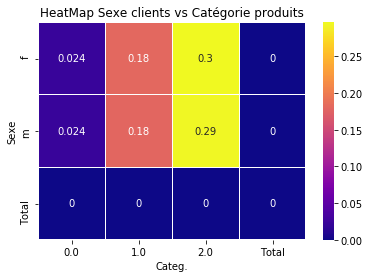

In [57]:
#afficher cette heatmap 
#Création de la "Matrice des valeurs attendues"
#L’occurrence attendue est simplement la fréquence que l’on devrait trouver dans une cellule 
#si l’hypothèse nulle était vraie.
tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]

#Valeurs totales observées
n = len(data_complet)

#Produit matriciel.
indep = tx.dot(ty) / n

c = cont.fillna(0) # On remplace les valeurs nulles par 0

#Matrice "écart au carré normalisé de la valeur attendue VS valeur observée"
measure = (c-indep)**2/indep

#Calcul du Chi2
#Tester l’hypothèse nulle consiste à comparer les occurrences observées (celles déjà dans le tableau) 
#avec les occurrences attendues.
xi_n = measure.sum().sum()

#HeatMap 
table = measure/xi_n
#sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1])
sns.heatmap(table, annot=True, cmap="plasma", linewidths=0.1)

plt.title('HeatMap Sexe clients vs Catégorie produits')
plt.xlabel('Categ.')
plt.ylabel('Sexe')
plt.show()

In [58]:
# Si p_value > à 0.05 ,l'Hypothèse H0 est donc retenu. Il n'existe pas de dépendance entre le genre du client et les catégories de livre achetés
# Si p-value < à 0.05 ,l'Hypothèse H1 est donc retenu.Il existe une dépendance entre le genre du client et les catégories de livre achet

#Calcul du khi2 et de la p-value à partir de la matrice des valeurs observées avec scipy 
#Degré de liberté = (nombre de lignes – 1) X (nombre de colonnes – 1)
chi2, pvalue, degrees, expected = st.chi2_contingency(cont)
chi2, degrees, pvalue

(147.11906816131497, 6, 3.144522803251581e-29)

 p-value (3e-29%) expose une valeur inférieure au seuil. L'hypothèse nulle est rejetée en faveur de l’hypothèse alternative, il existe donc un lien entre le sexe des clients et les catégories produits.

### 11.2 Analyse de la corrélation entre l'âge clients et le montant total des achats

Text(0.5, 1.0, 'Motant des achats par âges')

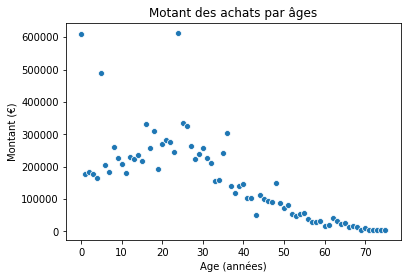

In [59]:
age = data_complet.groupby(["age"])["client_id"].count()
age_price = data_complet.groupby(["age"])["price"].sum().reset_index()

#Visualisation avec un scatterplot (âge clients vs montant total des achats)
sns.scatterplot(data= age_price['price'])
plt.ylabel("Montant (€)")
plt.xlabel("Age (années)")
plt.title("Motant des achats par âges")

In [60]:
# Correlation entre l'age et le montant total des achats: Coefficient de corrélation linéaire de Pearson
print("Corrélation de Pearson:", st.pearsonr(age_price["age"], age_price["price"])[0])

Corrélation de Pearson: -0.7788810457117031


Le coefficient étant négatif,  on peut affirmer que plus les consommateurs sont agés plus le montant total de leur achat est faible.

### 11.3 Analyse de la corrélation entre l'âge clients et la fréquence d'achat

In [61]:
customers_freq = data_complet.groupby('age')["session_id"].count().reset_index()
customers_freq.rename(columns={'session_id': 'freq'}, inplace = True)

customers_freq.head()

,age,freq
0,19,15149
1,20,4371
2,21,4584
3,22,4252
4,23,4413


Text(0.5, 1.0, "Fréquence mensuelle d'achat par âge")

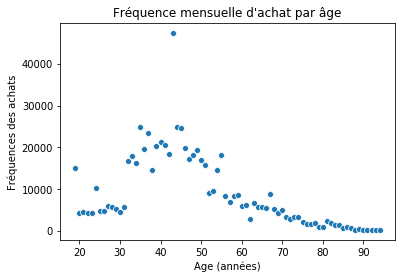

In [62]:
#Visualisation avec un scatterplot (âge client vs fréquence d'achat mensuelle)
sns.scatterplot(x=customers_freq['age'], y=customers_freq['freq'])
plt.ylabel("Fréquences des achats")
plt.xlabel("Age (années)")
plt.title("Fréquence mensuelle d'achat par âge")

In [68]:
#Coefficient de corrélation linéaire de Pearson
print("Corrélation de Pearson::", st.pearsonr(customers_freq.age, customers_freq.freq)[0])


Corrélation de Pearson:: -0.5337344271238335


Le coefficient étant négatif,  on peut affirmer que plus l'âge augmente, plus la fréquence d'achat baisse.

### 11.4 Analyse de la corrélation entre l'âge clients et la taille du panier moyen

In [64]:
panier_moy = data_complet.groupby('age').agg({'price':'sum','session_id':'count'}).reset_index()
panier_moy.head()


,age,price,session_id
0,19,609013.69,15149
1,20,178195.78,4371
2,21,184177.35,4584
3,22,178497.70,4252
4,23,165007.98,4413


In [65]:
panier_moy['panier_avg']= panier_moy['price']/panier_moy['session_id']
panier_moy.head()

,age,price,session_id,panier_avg
0,19,609013.69,15149,40.201577
1,20,178195.78,4371,40.767737
2,21,184177.35,4584,40.178305
3,22,178497.70,4252,41.979704
4,23,165007.98,4413,37.391339


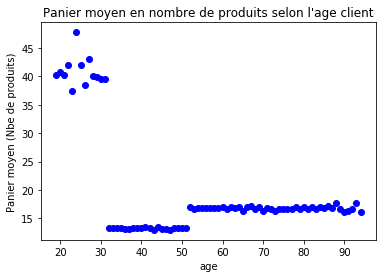

In [66]:
#Visualisation avec un scatterplot (âge client vs taille panier moyen)
plt.plot(panier_moy.age, panier_moy.panier_avg, 'o', color='b')

plt.xlabel('age')
plt.ylabel('Panier moyen (Nbe de produits)')
plt.title('Panier moyen en nombre de produits selon l\'age client')


plt.show()

In [73]:
# Correlation entre l'age et taille du panier
#Coefficient de corrélation linéaire de Pearson
print("Corrélation de Pearson::", st.pearsonr(panier_moy["age"], panier_moy["panier_avg"])[0])

Corrélation de Pearson:: -0.5478614363790837


le coeffient de correlation negatif, donc on une correlation negatif. Il existe 3 groupes d'ages

### 11.5 Analyse de la corrélation entre l'âge clients et la catégorie produits

L'âge des clients est-il différent en fonction de la catégorie d'achat ?

- H0 : La moyenne des âges des clients est identique quelque soit la catégorie d'achat
- H1 : Au moins l'une des moyennes des âges des clients est différentes en fonction de la catégorie d'achat
- Condition de validation du test ANOVA :

- Independence : On utilise la fonction sample() avec 1500 entrées
- Normalité : On vérifie la normalité de la variable Âge. Pour cela, on utilise le test de Shapiro
- Egalité des moyennes : on utilise  le test kurskal wallis 

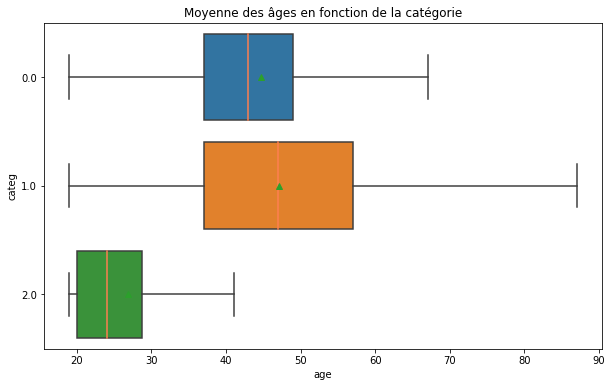

In [82]:
#Affichage du boxplot 
sample_data = data_complet.sample(1500)
plt.figure(figsize=(10,6))
plt.title("Moyenne des âges en fonction de la catégorie")
sns.boxplot(data=sample_data, x="age", y="categ", orient="h",showfliers=False, showmeans=True,medianprops={"color": "coral"})
plt.show()

Moyenne proche entre les catégories 0 et 1

Dans un test ANOVA, on cherche à déterminer si les moyennes sont significativement différentes.

H0 : Les moyennes de chaque groupe sont égales si p-value > 5% H1 : Les moyennes de chaque groupe ne sont pas toutes égales si p-value < 5%

In [69]:
#Test de normalité
stat, p = shapiro(sample_data["age"])
if p > 0.05:
    print("H0 : Les données ne semblent pas respecter une loi normale")
    print("p-value :",p)
else:
    print("H1 : Les données semblent respecter une loie normale")
    print("p-value :",p)

H1 : Les données semblent respecter une loie normale
p-value : 2.2639547436189775e-15


In [84]:
# Si p < 0.05, on peut rejeter l'hypothèse nulle selon laquelle les moyennes des groupes sont égales
if p < 0.05:
    print("Les moyennes des groupes sont significativement différentes.")
else:
    print("Les moyennes des groupes ne sont pas significativement différentes.")
from scipy import stats
stats.kruskal(sample_data["age"], sample_data["categ"])

Les moyennes des groupes sont significativement différentes.


KruskalResult(statistic=2324.8538589852888, pvalue=0.0)

In [87]:
# Test ANOVA
from scipy.stats import f_oneway
stat, p = f_oneway(sample_data["age"], sample_data["categ"])

#stat, p = ttest_ind()

if p > 0.05:
    print("H0: les moyennes des échantillons sont égales")
    print("pvalue : ",p)
else:
    print("H1: une ou plus des moyennes des échantillons sont inégales")
    print("pvalue : ",p)

H1: une ou plus des moyennes des échantillons sont inégales
pvalue :  0.0


Pour conclure, si au moins l'une des moyennes des échantillons sont inégales, cela signifique qu'il existe une corrélation entre l'âge du client et la catégorie des livres achetés